In [1]:
# general
import os
import sys
import numpy as np
import pandas as pd

# plots
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()
from IPython.display import Image

# predictions
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
drivers = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/drivers.csv")
driver_standings = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/driver_standings.csv", sep = ",")
driver_results = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/results.csv")
pit_stops = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/pit_stops.csv")
qualifying = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/qualifying.csv")
races = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/races.csv")
circuits = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/circuits.csv")

lap_times = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/lap_times.csv")
status = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/status.csv")
constructors = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/constructors.csv")
constructor_standings = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/constructor_standings.csv")
constructor_results = pd.read_csv("https://raw.githubusercontent.com/the-mcw/ML1/main/data/constructor_results.csv")

In [3]:
races_1 = races.loc[(races['year'] >= 2011) & (races['year'] <= 2020)].copy().iloc[:,0:6]
del races_1['name']
races_2 = pd.merge(races_1,circuits[['circuitId','country']], on = 'circuitId')
races_2.date = pd.to_datetime(races_2.date)
races_2.head()

,raceId,year,round,circuitId,date,country
0,841,2011,1,1,2011-03-27,Australia
1,860,2012,1,1,2012-03-18,Australia
2,880,2013,1,1,2013-03-17,Australia
3,900,2014,1,1,2014-03-16,Australia
4,926,2015,1,1,2015-03-15,Australia


In [4]:
#race_1 = pd.merge(races, pit_stops, on='raceId', how='outer')
#race_1 = race_1.rename(columns={'time_y':'TimeOfPitStop'})
#Filtering Race seasons 2011 - 2020
#race_2011_2020 = race_1.loc[(race_1['year'] >= 2011) & (race_1['year'] <= 2020)].copy()
#Convert duration attribute to numeric
#race_2011_2020["duration"] = pd.to_numeric(race_2011_2020["duration"], errors="coerce")
#pit_stops.head()
pits = pd.pivot_table(pit_stops, values='milliseconds', index= ['raceId','driverId'], columns='stop').reset_index()
pits['mean_stop'] = pits.mean(axis=1)
pits['stops'] = 6-pits.isna().sum(axis=1)
pits =pits[['raceId','driverId','mean_stop','stops']]
pits.columns.name = None
pits = pits.merge(races_2,on='raceId').drop(columns='circuitId')
#pits

In [5]:
drivers = drivers[['driverId','driverRef','dob','nationality']]
drivers['dob'] = pd.to_datetime(drivers.dob)
drivers.info()
#driver_standings = driver_standings.drop(columns=['driverStandingsId','positionText'])
driver_standings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857 entries, 0 to 856
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   driverId     857 non-null    int64         
 1   driverRef    857 non-null    object        
 2   dob          857 non-null    datetime64[ns]
 3   nationality  857 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 26.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33902 entries, 0 to 33901
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   driverStandingsId  33902 non-null  int64  
 1   raceId             33902 non-null  int64  
 2   driverId           33902 non-null  int64  
 3   points             33902 non-null  float64
 4   position           33902 non-null  int64  
 5   positionText       33902 non-null  object 
 6   wins               33902 non-null  

In [6]:
drivers_1 = pd.merge(drivers, driver_standings, on='driverId', how='outer')
#drivers_1.loc[drivers_1.driverId==155]

In [7]:
driver_results.position = driver_results.position.replace('\\N',np.NaN).astype(np.float64)
driver_results.rank = driver_results['rank'].replace('\\N',np.NaN).astype(np.float64)
driver_results = driver_results[['raceId','driverId','constructorId','grid','positionOrder','points','laps','rank','fastestLapTime','fastestLapSpeed','statusId']]
driver_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           25840 non-null  int64  
 1   driverId         25840 non-null  int64  
 2   constructorId    25840 non-null  int64  
 3   grid             25840 non-null  int64  
 4   positionOrder    25840 non-null  int64  
 5   points           25840 non-null  float64
 6   laps             25840 non-null  int64  
 7   rank             25840 non-null  object 
 8   fastestLapTime   25840 non-null  object 
 9   fastestLapSpeed  25840 non-null  object 
 10  statusId         25840 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 2.2+ MB


In [8]:
drivers_2 = pd.merge(drivers_1, driver_results, on=('driverId','raceId'), how='outer', suffixes=('Season','Race'))
#drivers_2

In [9]:
drivers_3 = pd.merge(drivers_2,pits, on=('raceId','driverId'))
drivers_3['rank'] = drivers_3['rank'].replace('\\N',np.NaN).astype(np.float64)
drivers_3['podium'] = drivers_3.positionOrder<4
drivers_3['top10'] = drivers_3.positionOrder<11

drivers_3.date = pd.to_datetime(drivers_3.date) 
drivers_3['age'] = (drivers_3.date-drivers_3.dob)/np.timedelta64(1,'Y')
del drivers_3['dob']
drivers_3['fastestLapSpeed'] = drivers_3['fastestLapSpeed'].replace('\\N',np.NaN).astype(np.float64)

In [10]:
qualifying['q1'] = qualifying.q1.replace('\\N',np.NaN)
qualifying['q2'] = qualifying.q2.replace('\\N',np.NaN)
qualifying['q3'] = qualifying.q3.replace('\\N',np.NaN)

# qualifying['q1s'] = pd.to_timedelta(qualifying['q1'], unit='ms', errors='ignore')#.dt.total_seconds().map('{:,.2f}'.format)
qualifying['q1s'] = pd.to_timedelta("00:0" + qualifying['q1']).dt.total_seconds()
qualifying['q2s'] = pd.to_timedelta("00:0" + qualifying['q2']).dt.total_seconds()
qualifying['q3s'] = pd.to_timedelta("00:0" + qualifying['q3']).dt.total_seconds()

qualifying['minQ'] = qualifying[['q1s','q2s','q3s']].min(axis=1)


In [11]:
# dropping 147 missing qualifying times 
qualifying = qualifying.loc[qualifying.minQ.notna()]
qualifying.minQ.isna().sum()

0

In [12]:
drivers_4 = drivers_3.drop(columns='driverStandingsId').merge(
    qualifying[['raceId','driverId','constructorId','position','minQ']],
    on=['raceId','driverId','constructorId'],
    suffixes=('Season','Qualify'))
drivers_4 = drivers_4.loc[drivers_4['driverRef'].notna()]
drivers_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 0 to 3827
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   driverId         3828 non-null   int64         
 1   driverRef        3828 non-null   object        
 2   nationality      3828 non-null   object        
 3   raceId           3828 non-null   float64       
 4   pointsSeason     3828 non-null   float64       
 5   positionSeason   3828 non-null   float64       
 6   positionText     3828 non-null   object        
 7   wins             3828 non-null   float64       
 8   constructorId    3828 non-null   float64       
 9   grid             3828 non-null   float64       
 10  positionOrder    3828 non-null   float64       
 11  pointsRace       3828 non-null   float64       
 12  laps             3828 non-null   float64       
 13  rank             3828 non-null   float64       
 14  fastestLapTime   3828 non-null   object 

In [13]:
id_changes = {
    209: 206,  # Manor Marussia
    208: 205,  # Lotus F1
    207: 32,   # Team Lotus
    211: 117,  # Racing Point
    10: 117,   # Force India
    5: 213,    # Toro Rosso
    15: 51     # Sauber
}

constructor_standings['constructorId'] = constructor_standings['constructorId'].replace(id_changes)

constructor_results['constructorId'] = constructor_results['constructorId'].replace(id_changes)

In [14]:
marussia = constructors[constructors['constructorId'] == 206]
#print(marussia)

lotus = constructors[constructors['constructorId'] == 205]
#print(lotus)

astonmartin = constructors[constructors['constructorId'] == 117]
#print(astonmartin)

alphatauri = constructors[constructors['constructorId'] == 213]
#print(alphatauri)

In [15]:
# Merge team_1 with constructor_results
team_1 = pd.merge(constructor_standings.drop(columns=['positionText','constructorStandingsId']), constructor_results.drop(columns=['status','constructorResultsId']), on=('constructorId','raceId'), how='outer')
team_1 = team_1.rename(columns={'points_x': 'ConstructorSeasonPoints', 'points_y': 'ConstructorRacePoints', 'wins': 'ConstructorWins','position':'ConstructorSeasonPosition'})
#team_1.loc[team_1.constructorId == 206].sort_values(by = 'raceId')

In [16]:
# removing duplicate rows
team_1 = team_1.loc[team_1.duplicated(subset=['constructorId','raceId'])==False]

In [17]:
drivers_4['constructorId'] = drivers_4['constructorId'].replace(id_changes)

drivers_5 = drivers_4.merge(team_1,on=['constructorId','raceId'])
drivers_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 0 to 3827
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   driverId                   3828 non-null   int64         
 1   driverRef                  3828 non-null   object        
 2   nationality                3828 non-null   object        
 3   raceId                     3828 non-null   float64       
 4   pointsSeason               3828 non-null   float64       
 5   positionSeason             3828 non-null   float64       
 6   positionText               3828 non-null   object        
 7   wins                       3828 non-null   float64       
 8   constructorId              3828 non-null   float64       
 9   grid                       3828 non-null   float64       
 10  positionOrder              3828 non-null   float64       
 11  pointsRace                 3828 non-null   float64       
 12  laps  

In [18]:
#shift podium to previous results
drivers_5['nextPodium'] = drivers_5.sort_values('raceId').groupby(['driverId','year'])['podium'].shift(-1)
drivers_5['nextTop10'] = drivers_5.sort_values('raceId').groupby(['driverId','year'])['top10'].shift(-1)
drivers_5['qualifyPosition'] = drivers_5.sort_values('raceId').groupby(['driverId','year'])['positionQualify'].shift(-1)
drivers_5['minQ'] = drivers_5.sort_values('raceId').groupby(['driverId','year'])['minQ'].shift(-1)

drivers_5.sort_values(['driverId', 'raceId'], ascending=True)[['driverId','raceId','year','positionQualify','podium','qualifyPosition','nextPodium']].head(20)

drivers_6 = drivers_5.drop(columns=['podium','positionText','grid', 'positionQualify', 'top10']).loc[drivers_5.nextPodium.notna(),:]

#driver_6 is used in modeling

In [19]:
#LogReg using GridSearch
#Y1 is for Podium 
X1 = drivers_6[['pointsSeason','qualifyPosition','minQ','positionOrder','laps','rank','mean_stop','stops','round','age','ConstructorSeasonPoints']]
Y1 = drivers_6['nextPodium']

encoder = LabelEncoder()
Y1_encoded = encoder.fit_transform(Y1)

#X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1_encoded, test_size=0.2, random_state=5)

#Stratified 10-fold CV
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=22)

#Iteration for the folds
for train_index, test_index in stratified_kfold.split(X1, Y1_encoded):
    X1_train, X1_test = X1.iloc[train_index], X1.iloc[test_index]
    y1_train, y1_test = Y1_encoded[train_index], Y1_encoded[test_index]

scl_obj = StandardScaler()
scl_obj.fit(X1_train)

X1_train_scaled = scl_obj.transform(X1_train) 
X1_test_scaled = scl_obj.transform(X1_test)

In [20]:
#Y2 is for Top10
X2 = drivers_6[['pointsSeason','qualifyPosition','minQ','positionOrder','laps','rank','mean_stop','stops','round','age','ConstructorSeasonPoints']]
Y2 = drivers_6['nextTop10']


encoder = LabelEncoder()
Y2_encoded = encoder.fit_transform(Y2)


#X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2_encoded, test_size=0.2, random_state=10)

#Stratified 10-fold CV
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=11)

#Iteration for the folds
for train_index, test_index in stratified_kfold.split(X2, Y2_encoded):
    X2_train, X2_test = X2.iloc[train_index], X2.iloc[test_index]
    y2_train, y2_test = Y2_encoded[train_index], Y2_encoded[test_index]

scl_obj = StandardScaler()
scl_obj.fit(X2_train)

X2_train_scaled = scl_obj.transform(X2_train) 
X2_test_scaled = scl_obj.transform(X2_test)

In [21]:
drivers_6.head()

,driverId,driverRef,nationality,raceId,pointsSeason,positionSeason,wins,constructorId,positionOrder,pointsRace,laps,rank,fastestLapTime,fastestLapSpeed,statusId,mean_stop,stops,year,round,date,country,age,minQ,ConstructorSeasonPoints,ConstructorSeasonPosition,ConstructorWins,ConstructorRacePoints,nextPodium,nextTop10,qualifyPosition
0,1,hamilton,British,969.0,18.0,2.0,0.0,131.0,2.0,18.0,57.0,6.0,1:27.033,219.351,1.0,7559.666667,1,2017,1,2017-03-26,Australia,32.214214,91.678,33.0,2.0,0.0,33.0,True,True,1.0
1,822,bottas,Finnish,969.0,15.0,3.0,0.0,131.0,3.0,15.0,57.0,2.0,1:26.593,220.465,1.0,7743.666667,1,2017,1,2017-03-26,Australia,27.576199,91.865,33.0,2.0,0.0,33.0,False,True,3.0
2,1,hamilton,British,842.0,22.0,3.0,0.0,1.0,8.0,4.0,56.0,5.0,1:41.512,196.575,1.0,15642.333333,4,2011,2,2011-04-10,Malaysia,26.253790,94.463,48.0,2.0,0.0,22.0,True,True,3.0
3,18,button,British,842.0,26.0,2.0,0.0,1.0,2.0,18.0,56.0,4.0,1:41.264,197.057,1.0,13642.800000,3,2011,2,2011-04-10,Malaysia,31.223092,94.421,48.0,2.0,0.0,22.0,False,True,2.0
4,1,hamilton,British,841.0,18.0,2.0,0.0,1.0,2.0,18.0,58.0,8.0,1:30.314,211.382,1.0,11817.000000,2,2011,1,2011-03-27,Australia,26.215460,94.974,26.0,2.0,0.0,26.0,False,True,2.0


In [22]:
# SVM Grid Search

parameter_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf']
}

SVM = SVC()

In [23]:
from sklearn.metrics import precision_score
#Y1 - Podium

gridsearch_svm1 = GridSearchCV(SVM, param_grid = parameter_svm, cv=stratified_kfold, refit = True, verbose = 3)
gridsearch_svm1.fit(X1_train_scaled, y1_train)

SVM_model1 = gridsearch_svm1.best_estimator_
SVM_params1 = gridsearch_svm1.best_params_

# Predictions
SVM_pred1 = SVM_model1.predict(X1_test_scaled)

# Accuracy
SVM_accuracy1 = accuracy_score(y1_test, SVM_pred1)

# Precision
SVM_precision1 = precision_score(y1_test, SVM_pred1)

print("Best Accuracy (Podium):", SVM_accuracy1)
print("Best Parameters (Podium):", SVM_params1)
print("Best Precision (Podium):", SVM_precision1)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END .............C=0.1, kernel=linear;, score=0.910 total time=   0.0s
[CV 2/10] END .............C=0.1, kernel=linear;, score=0.904 total time=   0.0s
[CV 3/10] END .............C=0.1, kernel=linear;, score=0.907 total time=   0.0s
[CV 4/10] END .............C=0.1, kernel=linear;, score=0.895 total time=   0.0s
[CV 5/10] END .............C=0.1, kernel=linear;, score=0.892 total time=   0.0s
[CV 6/10] END .............C=0.1, kernel=linear;, score=0.904 total time=   0.0s
[CV 7/10] END .............C=0.1, kernel=linear;, score=0.889 total time=   0.0s
[CV 8/10] END .............C=0.1, kernel=linear;, score=0.904 total time=   0.0s
[CV 9/10] END .............C=0.1, kernel=linear;, score=0.923 total time=   0.0s
[CV 10/10] END ............C=0.1, kernel=linear;, score=0.904 total time=   0.0s
[CV 1/10] END ................C=0.1, kernel=rbf;, score=0.867 total time=   0.0s
[CV 2/10] END ................C=0.1, kernel=rb

[[ 0.77916875 -1.3951635  -0.0457755  -0.0605099  -0.05245643 -0.0850389
   0.05163914 -0.05677167 -0.61686834 -0.04698779 -0.01652209]]


<Axes: >

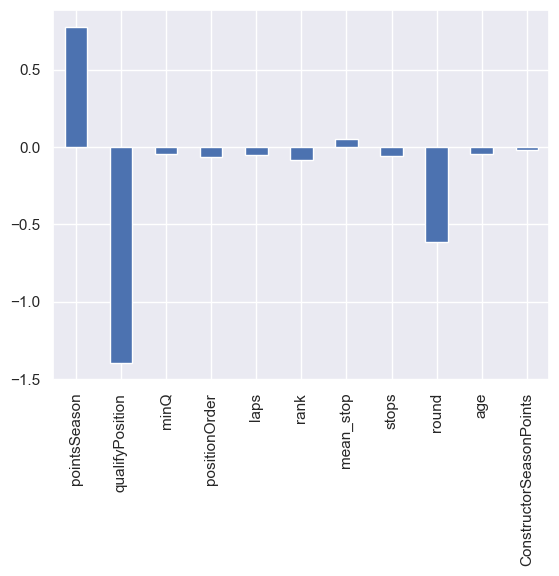

In [25]:
print(SVM_model1.coef_)
weights_SVM1 = pd.Series(SVM_model1.coef_[0],index=X1.columns)
weights_SVM1.plot(kind='bar')

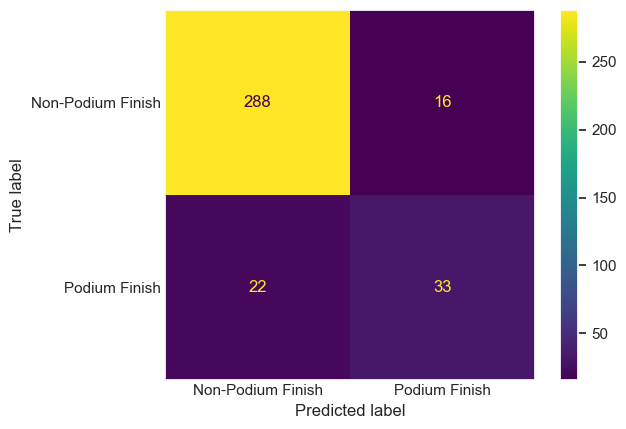

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


SVM_pred1 = SVM_model1.predict(X1_test_scaled)
ConfusionMatrixDisplay(confusion_matrix(y1_test,SVM_pred1),
                       display_labels={'Non-Podium Finish', 'Podium Finish'}).plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(visible=None)
plt.show()

In [27]:
#Y2 - Top10


gridsearch_svm2 = GridSearchCV(SVM, param_grid = parameter_svm, cv=stratified_kfold, refit = True, verbose = 3)
gridsearch_svm2.fit(X2_train_scaled, y2_train)

SVM_model2 = gridsearch_svm2.best_estimator_
SVM_params2 = gridsearch_svm2.best_params_

# Predictions
SVM_pred2 = SVM_model2.predict(X2_test_scaled)

# Accuracy
SVM_accuracy2 = accuracy_score(y2_test, SVM_pred2)

# Precision
SVM_precision2 = precision_score(y2_test, SVM_pred2)

print("Best Accuracy (Top10):", SVM_accuracy2)
print("Best Parameters (Top10):", SVM_params2)
print("Best Precision (Podium):", SVM_precision2)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END .............C=0.1, kernel=linear;, score=0.784 total time=   0.0s
[CV 2/10] END .............C=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 3/10] END .............C=0.1, kernel=linear;, score=0.790 total time=   0.0s
[CV 4/10] END .............C=0.1, kernel=linear;, score=0.796 total time=   0.0s
[CV 5/10] END .............C=0.1, kernel=linear;, score=0.812 total time=   0.0s
[CV 6/10] END .............C=0.1, kernel=linear;, score=0.762 total time=   0.0s
[CV 7/10] END .............C=0.1, kernel=linear;, score=0.852 total time=   0.0s
[CV 8/10] END .............C=0.1, kernel=linear;, score=0.786 total time=   0.0s
[CV 9/10] END .............C=0.1, kernel=linear;, score=0.783 total time=   0.0s
[CV 10/10] END ............C=0.1, kernel=linear;, score=0.762 total time=   0.0s
[CV 1/10] END ................C=0.1, kernel=rbf;, score=0.787 total time=   0.1s
[CV 2/10] END ................C=0.1, kernel=rb

In [30]:
SVM_params2

{'C': 1, 'kernel': 'rbf'}

In [29]:
print(SVM_model2.coef_)
weights_SVM2 = pd.Series(SVM_model2.coef_[0],index=X.columns)
weights_SVM2.plot(kind='bar')

AttributeError: coef_ is only available when using a linear kernel

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


SVM_pred2 = SVM_model2.predict(X2_test_scaled)
ConfusionMatrixDisplay(confusion_matrix(y2_test,SVM_pred2),
                       display_labels={'Top 10','Not Top 10'}).plot()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(visible=None)
plt.show()

In [ ]:
#Playing around with the confusion matrix...

from sklearn.metrics import confusion_matrix

# For SVM model 1
SVM_pred1 = SVM_model1.predict(X1_test_scaled)
ConfusionMatrixDisplay(confusion_matrix(y1_test,SVM_pred1),
                       display_labels={'Non-Podium Finish', 'Podium Finish'}).plot()

# Normalize the confusion matrix
cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.imshow(cm1, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - SVM Model 1')
plt.colorbar()
tick_marks = np.arange(len(labels1))
plt.xticks(tick_marks, labels1, rotation=45)
plt.yticks(tick_marks, labels1)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(visible=None)
plt.show()

Data Preparation:

For the final dataset used for the classification models, we kept only the relevant variables that we thought would influence a driver's liklihood to achieve a Podium or Top10 finish in a race. We removed highly correlated, redundant, and irrelavant variables like nationality and URL columns. 

To predict driver's performance based on the most recent race result, we created two new variables called "nextPodium" and "nextTop10". These were created to indicate whether a driver, considering all relevant variables such as race results, pitstop times, qualifying position, etc., would achieve podium or Top10 finish in the next race.

Lastly, we performed scaling on the X variables using the StandardScaler class. Scaling transforms the variables to have a mean of 0 and SD of 1, so that they are all on a similar scale for modeling purposes. 

Method of dividing Train/Test:

We chose to do a combination of Stratified 10-fold cross-validation and GridSearchCV for our analysis. Stratified 10-fold CV splits the dataset into 10 equal-sized folds while making sure that each fold has the same class distribution as the original dataset. This method is useful when the distribution of classes is uneven, especially when we are trying to predict Podium finish (the top 3 positions). GridSearchCV helps automate hyperparameter tuning, exploring a predefined set of values to choose the best combination that maximizes the model's performance. The combination of both of these methods provides more reliable estimates. 

In [ ]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_model, X, y, cv=10, scoring='accuracy')
rf_scores = cross_val_score(random_forest_model, X, y, cv=10, scoring='accuracy')
knn_scores = cross_val_score(knn_model, X, y, cv=10, scoring='accuracy')

#Mean and SD for each model
svm_mean = np.mean(svm_scores)
svm_std = np.std(svm_scores)

rf_mean = np.mean(rf_scores)
rf_std = np.std(rf_scores)

knn_mean = np.mean(knn_scores)
knn_std = np.std(knn_scores)

Advantages/Disadvantages of Each Model:

KNN:
Advantages - 

    - Simple algorithm, easy to understand. 
    - Can effectively capture non-linear relationships within data
    
Disadvantages -

    - As size of data increases, computational time signficantly increases
    - As it considers all features equally, model is sensitive to irrelevant features
    
    
Random Forrest:
Advantages - 

    - Allows us to see which features are most important/influential in making predictions
    - Combines multiple decision trees, which reduces overfitting
    
Disadvantages - 

    - More complex to train than KNN or linear regression. Can be challenging as it requires selecting the appropriate number of trees, and tuning parameters.
    - Less interpretable as understanding decision-making process of each tree within model can be difficult


Support Vector Machines:

Advantages -

    - performs well when there are a large number of features, can handle complex relationships
    - uses a regularization parameter that helps prevent overfitting
    
Disadvantages - 

    - SVM's training time is longer compared to other models, especially for larger datasets
    - Can be difficult to interpret and visualize, especially for non-linear kernels
    

H0 = There is no significant difference in the performance of the SVM, Random Forest, and KNN models.
H1 = There is a significant difference in the performance of the models.

Podium Finishes
SVM Precision: 0.894
Random Forrest Precision: 
KNN Precision:

Interpretation of Results:
    
SVM Model for Podium Finish - model for predicting podium finishes has an accuracy of 0.894, which means that the the model correctly classified around 89.4% of the test set. Best parameters of the model are C = 1 and Linear Kernel. Interpreting the weights, PointsSeason has the highest positive weight of 0.754, which suggests that a higher points in the current season are associated with a higher chance of getting a podium finish. QualifyPosition has highest negative weight of -1.368, indicating that the lower qualifying position (qualifying first means starting first on the grid) is associated with a higher chance of a podium finish. The rest of the features also contribute to the predicting model but to a lesser extent. 

SVM Model for Top10 Finish - model for predicting podium finishes has an accuracy of 0.763, which means that the the model correctly classified around 76.3% of the test set. Best parameters of the model are C = 10 and Linear Kernel. Interpreting the weights, ConstructorSeasonPoints has the highest positive weight of 0.754, which suggests that a higher points for the constructor/team of the driver in the current season are associated with a higher chance of getting a podium finish. Variables such as QualifyPosition, minQ, PositionOrder, Age have negative weights, suggesting that lower values of these features are associated with a higher chance of a top 10 finish.

Deployment: 


The model can be valuable for organizations that regularly broadcast the races like F1, ESPN, and SkySports. These organizations already use models to predict similar attributes, such as potential Pit Windows for each driver based on strategy. They can use our model to predict podium finishes and top 10 positions, which can be displayed during broadcasts and discussed in pre-race shows. The model's value can be measured by its accuracy in making predictions throughout the season.

To deploy the model, an API or a prediction service can be used where users input data, and predictions are returned on a need by need basis. Additional data points that could potentially enhance the model's predictability are weather conditions and real-time race data. Regular evaluations should be performed to ensure all relevant variables are considered. The model may need updates to adapt to changes in racing rules and the availability of new data. 
